## Mount Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Import Tensorflow

In [ ]:
%tensorflow_version 2.x

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


In [ ]:
import tensorflow as tf
print(tf.version)

<module 'tensorflow._api.v2.version' from '/usr/local/lib/python3.10/dist-packages/tensorflow/_api/v2/version/__init__.py'>


## Split Dataset Into Training and Validation

In [ ]:
from tensorflow.keras.utils import image_dataset_from_directory

DATASET_PATH = "/content/drive/MyDrive/pet_bowl_dataset"
IMG_SIZE = (32, 32)

training_dataset = image_dataset_from_directory(
    DATASET_PATH + "/train",
    labels = "inferred",
    image_size = IMG_SIZE,
    color_mode = "rgb",
    subset="training",
    seed = 42,
    validation_split = 0.2
)

validation_dataset = image_dataset_from_directory(
    DATASET_PATH + "/train",
    labels = "inferred",
    image_size = IMG_SIZE,
    color_mode = "rgb",
    subset="validation",
    seed = 42,
    validation_split = 0.2
)

testing_dataset = image_dataset_from_directory(
    DATASET_PATH + "/train",
    labels = "inferred",
    image_size = IMG_SIZE,
    color_mode = "rgb",
    subset="validation",
    seed = 42,
    validation_split = 0.1
)

Found 2194 files belonging to 4 classes.
Using 1756 files for training.
Found 2194 files belonging to 4 classes.
Using 438 files for validation.
Found 2194 files belonging to 4 classes.
Using 219 files for validation.


## Plot Data

In [ ]:
import matplotlib.pyplot as plt

### Training Dataset

In [ ]:
plt.figure(figsize=(10, 10))
for images, labels in training_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(int(labels[i]))

### Validation Dataset

In [ ]:
plt.figure(figsize=(10, 10))
for images, labels in validation_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(int(labels[i]))

### Testing Dataset

In [ ]:
plt.figure(figsize=(10, 10))
for images, labels in testing_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(int(labels[i]))

## Preprocessing Step

In [ ]:
resize = tf.keras.Sequential([
  tf.keras.layers.Resizing(IMG_SIZE[0], IMG_SIZE[1])
])

rescale = tf.keras.Sequential([
  tf.keras.layers.Rescaling(1./255)
])

data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomBrightness(0.1),
])

IMG_SIZE[0]

32

### Plotting

(-0.5, 89.5, 89.5, -0.5)

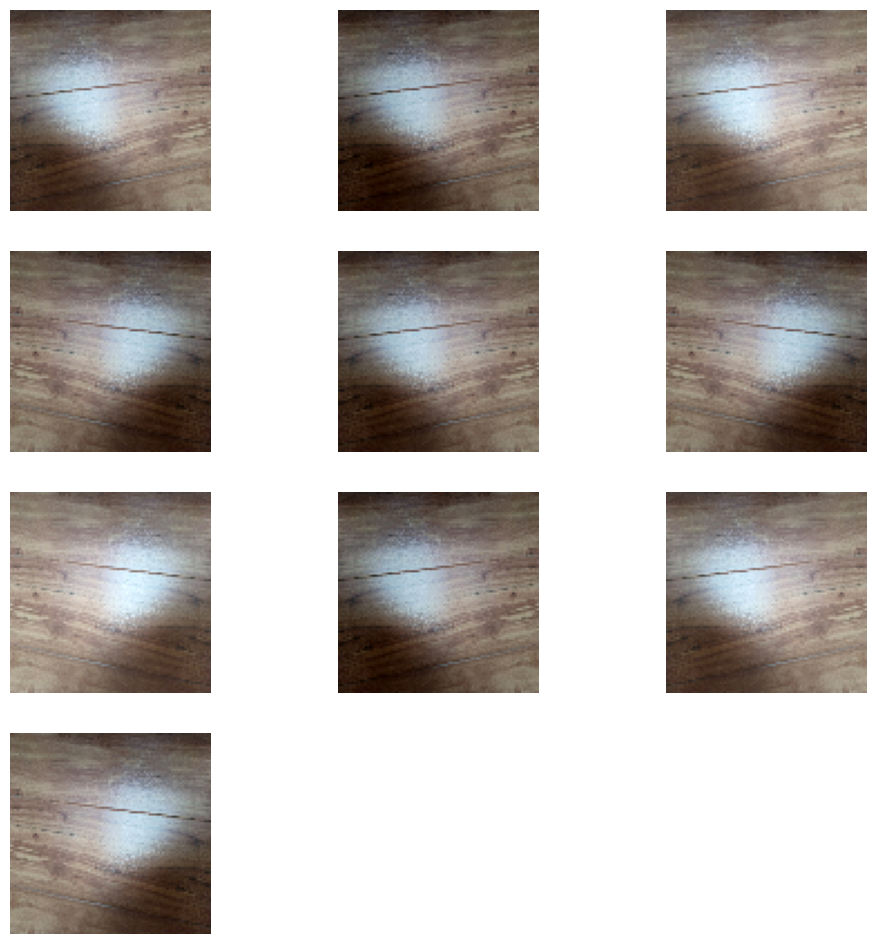

In [ ]:
image, label = next(iter(training_dataset.take(1)))
current_image = image

plt.figure(figsize=(12, 12))
for i in range(9):
  augmented_image = data_augmentation(current_image)
  ax = plt.subplot(4, 3, i + 1)
  plt.imshow(augmented_image[0].numpy().astype("uint8"))
  plt.axis("off")

ax = plt.subplot(4, 3, 10)
plt.imshow(current_image[0].numpy().astype("uint8"))
plt.axis("off")

### Cleaning Process

In [ ]:
def apply_data_augmentation_multiple_times(X, y, num_augmentations=6):
    augmented_images = [data_augmentation(X) for _ in range(num_augmentations)]
    return augmented_images

# cleaned_train_ds = training_dataset.map(
#     lambda X, y: (rescale(X), y),
#     num_parallel_calls=tf.data.AUTOTUNE
# )

cleaned_train_ds = training_dataset
cleaned_train_ds_copy = training_dataset

for _ in range(6):
  augmented_data = cleaned_train_ds_copy.map(
      lambda X, y: (data_augmentation(X), y),
      num_parallel_calls=tf.data.AUTOTUNE
  )

  cleaned_train_ds.concatenate(augmented_data)
  cleaned_train_ds_copy = training_dataset

cleaned_train_ds = training_dataset.map(
    lambda X, y: (rescale(X), y),
    num_parallel_calls=tf.data.AUTOTUNE
)

cleaned_val_ds = validation_dataset.map(
    lambda X, y: (rescale(X), y),
    num_parallel_calls=tf.data.AUTOTUNE
)

cleaned_test_ds = testing_dataset.map(
    lambda X, y: (rescale(X), y),
    num_parallel_calls=tf.data.AUTOTUNE
)

grayscaled_cleaned_train_ds = cleaned_train_ds.map(
    lambda X, y: (tf.image.rgb_to_grayscale(X), y),
    num_parallel_calls=tf.data.AUTOTUNE
)

grayscaled_cleaned_val_ds = validation_dataset.map(
    lambda X, y: (tf.image.rgb_to_grayscale(X), y),
    num_parallel_calls=tf.data.AUTOTUNE
)

grayscaled_cleaned_testing_ds = testing_dataset.map(
    lambda X, y: (tf.image.rgb_to_grayscale(X), y),
    num_parallel_calls=tf.data.AUTOTUNE
)

cleaned_train_ds = cleaned_train_ds.prefetch(buffer_size=tf.data.AUTOTUNE)
cleaned_val_ds = cleaned_val_ds.prefetch(buffer_size=tf.data.AUTOTUNE)
cleaned_test_ds = cleaned_test_ds.prefetch(buffer_size=tf.data.AUTOTUNE)

grayscaled_cleaned_train_ds = grayscaled_cleaned_train_ds.prefetch(buffer_size=tf.data.AUTOTUNE)
grayscaled_cleaned_val_ds = grayscaled_cleaned_val_ds.prefetch(buffer_size=tf.data.AUTOTUNE)
grayscaled_cleaned_testing_ds = grayscaled_cleaned_testing_ds.prefetch(buffer_size=tf.data.AUTOTUNE)

## Util Function

In [ ]:
import os
import cv2
import numpy as np

BASE_PATH = "/content/drive/MyDrive/pet_bowl_dataset/test1/"

def test_keras_model(model):
  for img_path in os.listdir(BASE_PATH):
    if img_path.endswith(".jpg") == False:
      continue

    test_img = cv2.imread(BASE_PATH + img_path)

    prediction = model.predict(tf.expand_dims(test_img, axis=0))

    print(f"{BASE_PATH}{img_path}\t{list(prediction)} | argmax: {np.argmax(prediction)}")

def test_tflite_model(interpreter):
  interpreter.allocate_tensors()

  input_details = interpreter.get_input_details()
  output_details = interpreter.get_output_details()

  for img_path in os.listdir(BASE_PATH):
    if img_path.endswith(".jpg") == False:
      continue

    test_img = cv2.imread(BASE_PATH + img_path)
    test_img = cv2.resize(test_img, (48, 48))
    test_img = cv2.cvtColor(test_img, cv2.COLOR_BGR2GRAY)

    test_img = np.expand_dims(test_img, axis=2)
    test_img = tf.expand_dims(test_img, axis=0)

    interpreter.set_tensor(input_details[0]['index'], test_img)

    interpreter.invoke()

    output_data = interpreter.get_tensor(output_details[0]['index'])

    print(f"{BASE_PATH}{img_path}\t{list(output_data)} | argmax: {np.argmax(output_data)}")

for img_path in os.listdir(BASE_PATH):
  if img_path.endswith(".jpg") == False:
    continue

In [ ]:
@tf.keras.saving.register_keras_serializable(package="PreprocessLayer")
class PreprocessLayer(tf.keras.layers.Layer):
  def __init__(self, height, width, **kwargs):
    super().__init__(**kwargs)
    self.height = height
    self.width= width

  def call(self, inputs):
    return tf.image.resize(inputs, [self.height, self.width])
    return tf.image.rgb_to_grayscale(inputs)

  def compute_output_shape(self, input_shape):
    input_shape = tf.TensorShape(input_shape).as_list()
    return tf.TensorShape([input_shape[0], self.height, self.width, 1])

  def get_config(self):
    base_config = super().get_config()
    config = {
        "height": self.height,
        "width": self.width,
    }

    return {**base_config, **config}

  @classmethod
  def from_config(cls, config):
    return cls(**config)


## Create and Train Model

### Grayscaled Model w/ AdamW Optimizer

In [ ]:
model = tf.keras.Sequential([
  PreprocessLayer(IMG_SIZE[0], IMG_SIZE[1]),
  tf.keras.layers.Conv2D(16, 3, padding='same', activation=tf.keras.layers.LeakyReLU()),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, padding='same', activation=tf.keras.layers.LeakyReLU()),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, padding='same', activation=tf.keras.layers.LeakyReLU()),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(64, activation=tf.keras.layers.LeakyReLU()),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(4, activation='softmax')
])

model.compile(optimizer=tf.keras.optimizers.AdamW(),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

epochs=10
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=3,
    verbose=1,
    restore_best_weights=True,
)

history = model.fit(
  cleaned_train_ds,
  validation_data=cleaned_val_ds,
  epochs=epochs,
  callbacks=[early_stopping]
)

Epoch 1/10
55/55 [==============================] - 934s 14s/step - loss: 0.9284 - accuracy: 0.5991 - val_loss: 0.5273 - val_accuracy: 0.7945
Epoch 2/10
55/55 [==============================] - 158s 3s/step - loss: 0.5062 - accuracy: 0.8087 - val_loss: 0.4178 - val_accuracy: 0.8425
Epoch 3/10
55/55 [==============================] - 155s 3s/step - loss: 0.3263 - accuracy: 0.8747 - val_loss: 0.3413 - val_accuracy: 0.8562
Epoch 4/10
55/55 [==============================] - 160s 3s/step - loss: 0.2837 - accuracy: 0.8958 - val_loss: 0.2771 - val_accuracy: 0.8744
Epoch 5/10
55/55 [==============================] - 166s 3s/step - loss: 0.2445 - accuracy: 0.9117 - val_loss: 0.2289 - val_accuracy: 0.9064
Epoch 6/10
55/55 [==============================] - 167s 3s/step - loss: 0.2004 - accuracy: 0.9271 - val_loss: 0.1791 - val_accuracy: 0.9292
Epoch 7/10
55/55 [==============================] - 160s 3s/step - loss: 0.1701 - accuracy: 0.9419 - val_loss: 0.1798 - val_accuracy: 0.9315
Epoch 8/10
5

In [ ]:
model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 preprocess_layer_4 (Preproc  (None, 32, 32, 3)        0         
 essLayer)                                                       
                                                                 
 conv2d_12 (Conv2D)          (None, 32, 32, 16)        448       
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 16, 16, 16)       0         
 g2D)                                                            
                                                                 
 conv2d_13 (Conv2D)          (None, 16, 16, 32)        4640      
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 8, 8, 32)         0         
 g2D)                                                            
                                                      

#### Save and Load Model

In [ ]:
model.save("/content/drive/MyDrive/cnn_training/pet_bowl_classification/fifth_iter/cnn_grayscale_adamw_leaky_32_2.keras", save_format="keras")

In [ ]:
loaded_adamw_model = tf.keras.models.load_model("/content/drive/MyDrive/cnn_training/pet_bowl_classification/fifth_iter/cnn_grayscale_adamw_leaky_32_2.keras")
# test_loss, test_acc = loaded_adamw_model.evaluate(grayscaled_cleaned_val_ds, verbose=2)

In [ ]:
test_loss, test_acc = loaded_adamw_model.evaluate(cleaned_test_ds, verbose=2)

#### Learning Curve

7/7 - 19s - loss: 32.7941 - accuracy: 0.8630 - 19s/epoch - 3s/step


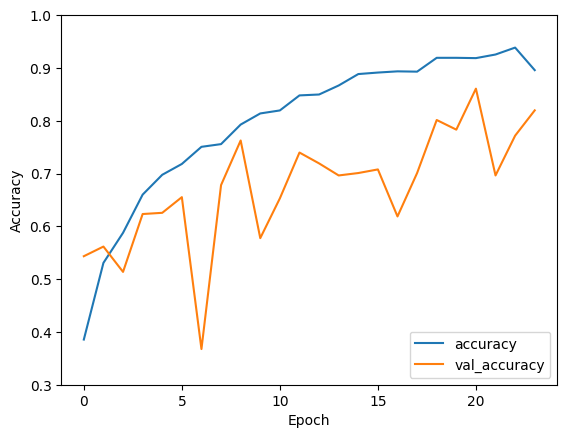

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.3, 1])
plt.legend(loc='lower right')

test_loss, test_acc = loaded_sgd_model.evaluate(grayscaled_cleaned_testing_ds, verbose=2)

#### Confusion Matrix

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay
import numpy as np

y_true = []
y_pred = []

for images, labels in cleaned_test_ds:
    predictions = loaded_adamw_model.predict(images)

    # Convert softmax probabilities to class labels
    predicted_labels = np.argmax(predictions, axis=1)

    y_true.extend(labels)
    y_pred.extend(predicted_labels)

cm = tf.math.confusion_matrix(y_true, y_pred, num_classes=4)

# Convert the TensorFlow tensor to a NumPy array for easier manipulation
confusion_matrix = cm.numpy()

# Print or use the confusion matrix as needed
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix, display_labels=['empty_bowl', 'full_bowl', 'lantai', 'unfinished_bowl'])
disp.plot()

#### Test with new data

In [ ]:
test_keras_model(loaded_adamw_model)

#### Convert to Tflite

In [ ]:
def representative_data_gen():
  for batch_images, _ in grayscaled_cleaned_train_ds: # We ignore labels here
      yield [batch_images]

converter = tf.lite.TFLiteConverter.from_keras_model(loaded_adamw_model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.representative_dataset = representative_data_gen
# Ensure that if any ops can't be quantized, the converter throws an error
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
# Set the input and output tensors to uint8 (APIs added in r2.3)
converter.inference_input_type = tf.uint8
converter.inference_output_type = tf.uint8
tflite_model = converter.convert()

/usr/local/lib/python3.10/dist-packages/tensorflow/lite/python/convert.py:789: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn("Statistics for quantized inputs were expected, but not "


In [ ]:
with open('/content/drive/MyDrive/cnn_training/pet_bowl_classification/fourth_iter/lite/cnn_grayscale_adamw_leaky_32_2.tflite', 'wb') as f:
  f.write(tflite_model)

#### Test TFLite model

In [ ]:

interpreter = tf.lite.Interpreter(model_path="/content/drive/MyDrive/cnn_training/pet_bowl_classification/third_iter/lite/cnn_grayscale_adamw_leaky.tflite")

test_tflite_model(interpreter)

/content/drive/MyDrive/pet_bowl_dataset/test1/empty_6.jpg	[array([216,   0,  21,  19], dtype=uint8)] | argmax: 0
/content/drive/MyDrive/pet_bowl_dataset/test1/empty_5.jpg	[array([186,   1,  24,  45], dtype=uint8)] | argmax: 0
/content/drive/MyDrive/pet_bowl_dataset/test1/empty_4.jpg	[array([212,   0,  13,  31], dtype=uint8)] | argmax: 0
/content/drive/MyDrive/pet_bowl_dataset/test1/empty_3.jpg	[array([194,   0,  25,  37], dtype=uint8)] | argmax: 0
/content/drive/MyDrive/pet_bowl_dataset/test1/empty_2.jpg	[array([126,  16,   2, 111], dtype=uint8)] | argmax: 0
/content/drive/MyDrive/pet_bowl_dataset/test1/empty_1.jpg	[array([179,   4,   9,  64], dtype=uint8)] | argmax: 0
/content/drive/MyDrive/pet_bowl_dataset/test1/full_test.jpg	[array([ 15,  63,   0, 177], dtype=uint8)] | argmax: 3
/content/drive/MyDrive/pet_bowl_dataset/test1/full_test_2.jpg	[array([  8, 162,   0,  85], dtype=uint8)] | argmax: 1
/content/drive/MyDrive/pet_bowl_dataset/test1/unfinished_bowl.jpg	[array([150,  17,   0,  

### Grayscaled Model w/ ADAM Optimizer

#### Create Model

In [ ]:
model = tf.keras.Sequential([
  tf.keras.layers.Resizing(IMG_SIZE[0], IMG_SIZE[1], interpolation='lanczos3'),
  GrayscaleLayer(),
  tf.keras.layers.Conv2D(16, 3, padding='same', activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, padding='same', activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, padding='same', activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(64, activation='relu'),
  # tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(4, activation='softmax')
])

model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

ValueError: ignored

#### Train Model

In [ ]:
epochs=10
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=3,
    verbose=1,
    restore_best_weights=True,
)

history = model.fit(
  cleaned_train_ds,
  validation_data=cleaned_val_ds,
  epochs=epochs,
  callbacks=[early_stopping]
)

Epoch 1/10
55/55 [==============================] - 243s 4s/step - loss: 0.1424 - accuracy: 0.9499 - val_loss: 0.1553 - val_accuracy: 0.9429
Epoch 2/10
55/55 [==============================] - 198s 3s/step - loss: 0.1243 - accuracy: 0.9590 - val_loss: 0.1670 - val_accuracy: 0.9361
Epoch 3/10
55/55 [==============================] - 192s 3s/step - loss: 0.1112 - accuracy: 0.9647 - val_loss: 0.1192 - val_accuracy: 0.9635
Epoch 4/10
55/55 [==============================] - 191s 3s/step - loss: 0.0779 - accuracy: 0.9755 - val_loss: 0.1234 - val_accuracy: 0.9543
Epoch 5/10
55/55 [==============================] - 197s 3s/step - loss: 0.0838 - accuracy: 0.9704 - val_loss: 0.1144 - val_accuracy: 0.9589
Epoch 6/10
55/55 [==============================] - 192s 3s/step - loss: 0.0639 - accuracy: 0.9795 - val_loss: 0.1166 - val_accuracy: 0.9566
Epoch 7/10
55/55 [==============================] - 230s 4s/step - loss: 0.0558 - accuracy: 0.9784 - val_loss: 0.1060 - val_accuracy: 0.9635
Epoch 8/10
55

In [ ]:
model.summary()

Model: "sequential_42"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resizing_24 (Resizing)      (None, 32, 32, 3)         0         
                                                                 
 grayscale_layer_8 (Grayscal  (None, 32, 32, 1)        0         
 eLayer)                                                         
                                                                 
 conv2d_117 (Conv2D)         (None, 32, 32, 16)        160       
                                                                 
 max_pooling2d_117 (MaxPooli  (None, 16, 16, 16)       0         
 ng2D)                                                           
                                                                 
 conv2d_118 (Conv2D)         (None, 16, 16, 32)        4640      
                                                                 
 max_pooling2d_118 (MaxPooli  (None, 8, 8, 32)       

#### Save Model

In [ ]:
SAVED_MODEL_PATH = "/content/drive/MyDrive/cnn_training/pet_bowl_classification/fifth_iter/cnn_keras_grayscale_adam_relu.keras"
model.save(SAVED_MODEL_PATH, save_format="keras")

#### Learning Curve

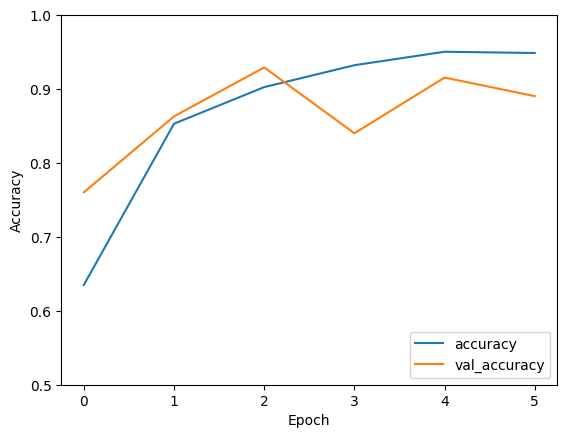

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

#### Load Model

In [ ]:
loaded_adam_model = tf.keras.models.load_model("/content/drive/MyDrive/cnn_training/pet_bowl_classification/fifth_iter/cnn_keras_grayscale_adam_relu.keras")
# test_loss, test_acc = loaded_adam_model.evaluate(cleaned_test_ds, verbose=2)

ValueError: ignored

#### Test With New Data

In [ ]:
test_keras_model(loaded_adam_model)

1/1 [==============================] - 1s 580ms/step
/content/drive/MyDrive/pet_bowl_dataset/test1/full_test.jpg	[array([0., 1., 0., 0.], dtype=float32)] | argmax: 1
1/1 [==============================] - 0s 171ms/step
/content/drive/MyDrive/pet_bowl_dataset/test1/full_test_2.jpg	[array([0., 1., 0., 0.], dtype=float32)] | argmax: 1
1/1 [==============================] - 1s 622ms/step
/content/drive/MyDrive/pet_bowl_dataset/test1/unfinished_bowl.jpg	[array([0., 1., 0., 0.], dtype=float32)] | argmax: 1
1/1 [==============================] - 0s 372ms/step
/content/drive/MyDrive/pet_bowl_dataset/test1/unfinished_bowl_2.jpg	[array([0., 1., 0., 0.], dtype=float32)] | argmax: 1
1/1 [==============================] - 0s 299ms/step
/content/drive/MyDrive/pet_bowl_dataset/test1/unfinished_bowl_3.jpg	[array([0., 0., 0., 1.], dtype=float32)] | argmax: 3
1/1 [==============================] - 0s 312ms/step
/content/drive/MyDrive/pet_bowl_dataset/test1/unfinished_bowl_4.jpg	[array([0., 1., 0., 0.], 

#### Confusion Matrix

1/1 [==============================] - 0s 274ms/step


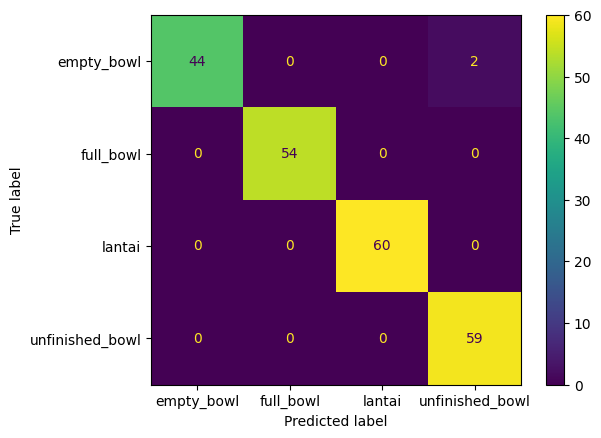

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay
import numpy as np

y_true = []
y_pred = []

for images, labels in cleaned_test_ds:
    predictions = loaded_adam_model.predict(images)

    # Convert softmax probabilities to class labels
    predicted_labels = np.argmax(predictions, axis=1)

    y_true.extend(labels)
    y_pred.extend(predicted_labels)

cm = tf.math.confusion_matrix(y_true, y_pred, num_classes=4)

# Convert the TensorFlow tensor to a NumPy array for easier manipulation
confusion_matrix = cm.numpy()

# Print or use the confusion matrix as needed
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix, display_labels=['empty_bowl', 'full_bowl', 'lantai', 'unfinished_bowl'])
disp.plot()

#### Convert To tflite Format

In [ ]:
def representative_data_gen():
  for batch_images, _ in grayscaled_cleaned_train_ds: # We ignore labels here
      yield [batch_images]

converter = tf.lite.TFLiteConverter.from_keras_model(loaded_adam_model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.allow_custom_ops = True
converter.representative_dataset = representative_data_gen
# Ensure that if any ops can't be quantized, the converter throws an error
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
converter.experimental_new_converter = True
# Set the input and output tensors to uint8 (APIs added in r2.3)
converter.inference_input_type = tf.uint8
converter.inference_output_type = tf.uint8
tflite_model = converter.convert()

/usr/local/lib/python3.10/dist-packages/tensorflow/lite/python/convert.py:789: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn("Statistics for quantized inputs were expected, but not "


RuntimeError: ignored

In [ ]:
with open('/content/drive/MyDrive/cnn_training/pet_bowl_classification/fifth_iter/lite/cnn_grayscale_adam_relu_32.tflite', 'wb') as f:
  f.write(tflite_model)

#### Test Tflite model

In [ ]:
interpreter = tf.lite.Interpreter(model_path="/content/drive/MyDrive/cnn_training/pet_bowl_classification/third_iter/lite/cnn_grayscale_adam_leaky_48.tflite")
test_tflite_model(interpreter)

/content/drive/MyDrive/pet_bowl_dataset/test1/full_test.jpg	[array([  0, 214,   0,  42], dtype=uint8)] | argmax: 1
/content/drive/MyDrive/pet_bowl_dataset/test1/full_test_2.jpg	[array([  0, 239,   0,  17], dtype=uint8)] | argmax: 1
/content/drive/MyDrive/pet_bowl_dataset/test1/unfinished_bowl.jpg	[array([ 47,  30,   0, 179], dtype=uint8)] | argmax: 3
/content/drive/MyDrive/pet_bowl_dataset/test1/unfinished_bowl_2.jpg	[array([ 47,  30,   0, 179], dtype=uint8)] | argmax: 3
/content/drive/MyDrive/pet_bowl_dataset/test1/unfinished_bowl_3.jpg	[array([ 65,   8,   0, 183], dtype=uint8)] | argmax: 3
/content/drive/MyDrive/pet_bowl_dataset/test1/unfinished_bowl_4.jpg	[array([  7,  97,   0, 152], dtype=uint8)] | argmax: 3
/content/drive/MyDrive/pet_bowl_dataset/test1/unfinished_5.jpg	[array([  4, 210,   1,  41], dtype=uint8)] | argmax: 1
/content/drive/MyDrive/pet_bowl_dataset/test1/kinda_unfinished (1).jpg	[array([  0, 234,   0,  22], dtype=uint8)] | argmax: 1
/content/drive/MyDrive/pet_bowl_da

### Grayscaled w/ ADAM Optimizer and Leaky ReLU

In [ ]:
model = tf.keras.Sequential([
  tf.keras.layers.Conv2D(16, 3, padding='same', activation=tf.keras.layers.LeakyReLU(), input_shape=(IMG_SIZE[0], IMG_SIZE[1], 1)),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, padding='same', activation=tf.keras.layers.LeakyReLU()),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(64, 3, padding='same', activation=tf.keras.layers.LeakyReLU()),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(64, activation=tf.keras.layers.LeakyReLU()),
  tf.keras.layers.Dropout(0.3),
  tf.keras.layers.Dense(4, activation='softmax')
])

model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

epochs=10
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=3,
    verbose=1,
    restore_best_weights=True,
)

history = model.fit(
  grayscaled_cleaned_train_ds,
  validation_data=grayscaled_cleaned_val_ds,
  epochs=epochs,
  callbacks=[early_stopping]
)

Epoch 1/10
55/55 [==============================] - 218s 4s/step - loss: 0.9072 - accuracy: 0.6145 - val_loss: 59.3608 - val_accuracy: 0.7511
Epoch 2/10
55/55 [==============================] - 221s 4s/step - loss: 0.4535 - accuracy: 0.8109 - val_loss: 40.8650 - val_accuracy: 0.7900
Epoch 3/10
55/55 [==============================] - 210s 3s/step - loss: 0.3532 - accuracy: 0.8593 - val_loss: 47.7233 - val_accuracy: 0.8242
Epoch 4/10
55/55 [==============================] - 205s 3s/step - loss: 0.3115 - accuracy: 0.8747 - val_loss: 22.2583 - val_accuracy: 0.8881
Epoch 5/10
55/55 [==============================] - 212s 3s/step - loss: 0.2491 - accuracy: 0.9089 - val_loss: 22.2011 - val_accuracy: 0.9018
Epoch 6/10
55/55 [==============================] - 241s 4s/step - loss: 0.2205 - accuracy: 0.9151 - val_loss: 39.4652 - val_accuracy: 0.8676
Epoch 7/10
55/55 [==============================] - 251s 4s/step - loss: 0.1820 - accuracy: 0.9356 - val_loss: 43.0673 - val_accuracy: 0.8653
Epoch 

In [ ]:
SAVED_MODEL_PATH = "/content/drive/MyDrive/cnn_training/pet_bowl_classification/fourth_iter/cnn_grayscale_adam_leaky_32_2.keras"
model.save(SAVED_MODEL_PATH, save_format="keras")

In [ ]:
SAVED_MODEL_PATH = "/content/drive/MyDrive/cnn_training/pet_bowl_classification/third_iter/cnn_grayscale_adam_leaky.keras"
model.save(SAVED_MODEL_PATH, save_format="keras")

#### Leaning Curve

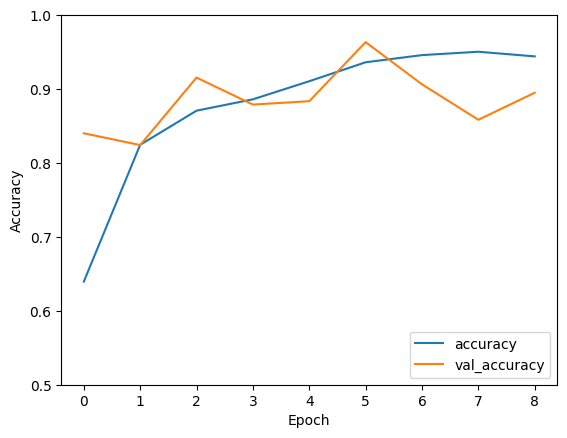

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

#### Load Model

In [ ]:
loaded_adam_leaky_model = tf.keras.models.load_model("/content/drive/MyDrive/cnn_training/pet_bowl_classification/fourth_iter/cnn_grayscale_adam_leaky_40_2.keras")
# test_loss, test_acc = loaded_adam_leaky_model.evaluate(grayscaled_cleaned_val_ds, verbose=2)

In [ ]:
loaded_first_iter_model = tf.keras.models.load_model("/content/drive/MyDrive/cnn_training/pet_bowl_classification/cnn_v1_maxpool_keras_grayscale_2.keras")
test_loss, test_acc = loaded_first_iter_model.evaluate(grayscaled_cleaned_val_ds, verbose=2)

14/14 - 61s - loss: 46.3418 - accuracy: 0.7397 - 61s/epoch - 4s/step


In [ ]:
test_loss, test_acc = loaded_adam_leaky_model.evaluate(grayscaled_cleaned_testing_ds, verbose=2)

7/7 - 27s - loss: 12.7756 - accuracy: 0.9498 - 27s/epoch - 4s/step


#### Confusion Matrix

1/1 [==============================] - 0s 152ms/step


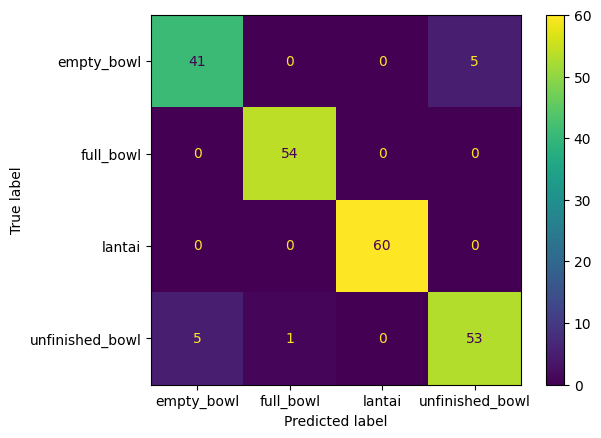

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay
import numpy as np

y_true = []
y_pred = []

for images, labels in grayscaled_cleaned_testing_ds:
    predictions = loaded_adam_leaky_model.predict(images)

    # Convert softmax probabilities to class labels
    predicted_labels = np.argmax(predictions, axis=1)

    y_true.extend(labels)
    y_pred.extend(predicted_labels)

cm = tf.math.confusion_matrix(y_true, y_pred, num_classes=4)

# Convert the TensorFlow tensor to a NumPy array for easier manipulation
confusion_matrix = cm.numpy()

# Print or use the confusion matrix as needed
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix, display_labels=['empty_bowl', 'full_bowl', 'lantai', 'unfinished_bowl'])
disp.plot()

#### Test With New Data

In [ ]:
test_keras_model(loaded_adam_leaky_model)

1/1 [==============================] - 0s 39ms/step
/content/drive/MyDrive/pet_bowl_dataset/test1/empty_6.jpg	[array([1., 0., 0., 0.], dtype=float32)] | argmax: 0
1/1 [==============================] - 0s 29ms/step
/content/drive/MyDrive/pet_bowl_dataset/test1/empty_5.jpg	[array([1., 0., 0., 0.], dtype=float32)] | argmax: 0
1/1 [==============================] - 0s 33ms/step
/content/drive/MyDrive/pet_bowl_dataset/test1/empty_4.jpg	[array([1., 0., 0., 0.], dtype=float32)] | argmax: 0
1/1 [==============================] - 0s 30ms/step
/content/drive/MyDrive/pet_bowl_dataset/test1/empty_3.jpg	[array([1., 0., 0., 0.], dtype=float32)] | argmax: 0
1/1 [==============================] - 0s 32ms/step
/content/drive/MyDrive/pet_bowl_dataset/test1/empty_2.jpg	[array([1., 0., 0., 0.], dtype=float32)] | argmax: 0
1/1 [==============================] - 0s 35ms/step
/content/drive/MyDrive/pet_bowl_dataset/test1/empty_1.jpg	[array([1., 0., 0., 0.], dtype=float32)] | argmax: 0
1/1 [=================

#### Convert to TFlite Format

In [ ]:
def representative_data_gen():
  for batch_images, _ in grayscaled_cleaned_train_ds: # We ignore labels here
      yield [batch_images]

converter = tf.lite.TFLiteConverter.from_keras_model(loaded_adam_leaky_model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.representative_dataset = representative_data_gen
# Ensure that if any ops can't be quantized, the converter throws an error
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
# Set the input and output tensors to uint8 (APIs added in r2.3)
converter.inference_input_type = tf.uint8
converter.inference_output_type = tf.uint8
tflite_model = converter.convert()

/usr/local/lib/python3.10/dist-packages/tensorflow/lite/python/convert.py:789: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn("Statistics for quantized inputs were expected, but not "


In [ ]:
with open('/content/drive/MyDrive/cnn_training/pet_bowl_classification/fourth_iter/lite/cnn_grayscale_adam_leaky_32_2.tflite', 'wb') as f:
  f.write(tflite_model)

#### Test Tflite Model

In [ ]:
# Load the TFLite model
interpreter = tf.lite.Interpreter(model_path="/content/drive/MyDrive/cnn_training/pet_bowl_classification/fourth_iter/lite/cnn_grayscale_adam_leaky_32_2.tflite")
test_tflite_model(interpreter)

/content/drive/MyDrive/pet_bowl_dataset/test1/empty_6.jpg	[array([251,   0,   1,   4], dtype=uint8)] | argmax: 0
/content/drive/MyDrive/pet_bowl_dataset/test1/empty_5.jpg	[array([208,   0,   4,  44], dtype=uint8)] | argmax: 0
/content/drive/MyDrive/pet_bowl_dataset/test1/empty_4.jpg	[array([249,   0,   0,   7], dtype=uint8)] | argmax: 0
/content/drive/MyDrive/pet_bowl_dataset/test1/empty_3.jpg	[array([231,   0,   2,  23], dtype=uint8)] | argmax: 0
/content/drive/MyDrive/pet_bowl_dataset/test1/empty_2.jpg	[array([119,   1,   0, 135], dtype=uint8)] | argmax: 3
/content/drive/MyDrive/pet_bowl_dataset/test1/empty_1.jpg	[array([199,   0,   1,  55], dtype=uint8)] | argmax: 0
/content/drive/MyDrive/pet_bowl_dataset/test1/full_test.jpg	[array([  3,  73,   0, 180], dtype=uint8)] | argmax: 3
/content/drive/MyDrive/pet_bowl_dataset/test1/full_test_2.jpg	[array([  1, 219,   0,  36], dtype=uint8)] | argmax: 1
/content/drive/MyDrive/pet_bowl_dataset/test1/unfinished_bowl.jpg	[array([113,  76,   0,  

#### Confusion Matrix

1/1 [==============================] - 0s 110ms/step


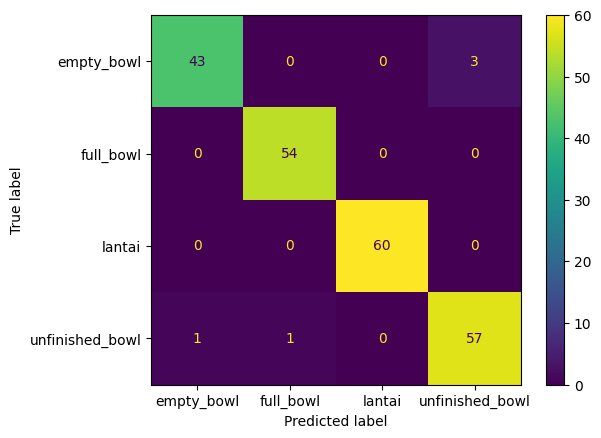

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay
import numpy as np

y_true = []
y_pred = []

for images, labels in grayscaled_cleaned_testing_ds:
    predictions = loaded_adam_leaky_model.predict(images)

    # Convert softmax probabilities to class labels
    predicted_labels = np.argmax(predictions, axis=1)

    y_true.extend(labels)
    y_pred.extend(predicted_labels)

cm = tf.math.confusion_matrix(y_true, y_pred, num_classes=4)

# Convert the TensorFlow tensor to a NumPy array for easier manipulation
confusion_matrix = cm.numpy()

# Print or use the confusion matrix as needed
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix, display_labels=['empty_bowl', 'full_bowl', 'lantai', 'unfinished_bowl'])
disp.plot()

### Confusion Matrix

1/1 [==============================] - 0s 190ms/step


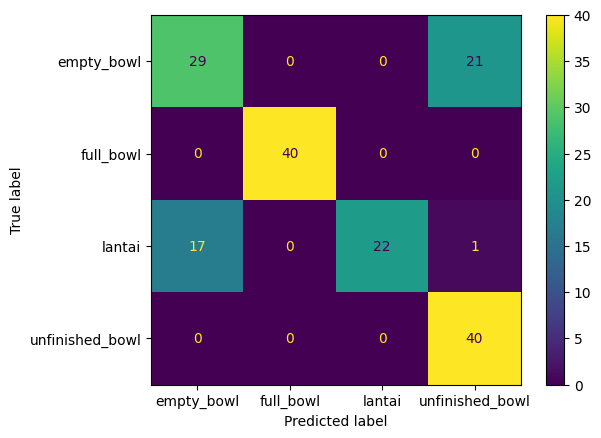

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay
import numpy as np

y_true = []
y_pred = []

for images, labels in grayscaled_test_ds:
    predictions = loaded_model.predict(images)

    # Convert softmax probabilities to class labels
    predicted_labels = np.argmax(predictions, axis=1)

    y_true.extend(labels)
    y_pred.extend(predicted_labels)

cm = tf.math.confusion_matrix(y_true, y_pred, num_classes=4)

# Convert the TensorFlow tensor to a NumPy array for easier manipulation
confusion_matrix = cm.numpy()

# Print or use the confusion matrix as needed
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix, display_labels=['empty_bowl', 'full_bowl', 'lantai', 'unfinished_bowl'])
disp.plot()

### Test with new data

In [ ]:
import cv2
import numpy as np

test_img = cv2.imread("/content/drive/MyDrive/pet_bowl_dataset/test1/unfinished_5.jpg")
# test_img = cv2.rotate(test_img, cv2.ROTATE_180)
test_img = cv2.resize(test_img, IMG_SIZE)
cv2.normalize(test_img, test_img, 0, 255, cv2.NORM_MINMAX)
test_img = cv2.cvtColor(test_img, cv2.COLOR_BGR2GRAY)

In [ ]:
%%time

prediction = loaded_adam_leaky_model.predict(tf.expand_dims(test_img, axis=0))

print(list(prediction))
print(f"Output: {np.argmax(prediction)}")

1/1 [==============================] - 0s 24ms/step
[array([0., 1., 0., 0.], dtype=float32)]
Output: 1
CPU times: user 78.2 ms, sys: 981 µs, total: 79.2 ms
Wall time: 78.6 ms


In [ ]:
%%time

import cv2

test_img = cv2.imread("/content/drive/MyDrive/pet_bowl_dataset/test1/unfinished_bowl_4.jpg")
# test_img = cv2.rotate(test_img, cv2.ROTATE_180)
test_img = cv2.resize(test_img, IMG_SIZE)
test_img = cv2.cvtColor(test_img, cv2.COLOR_BGR2GRAY)

prediction = loaded_adamw_model.predict(tf.expand_dims(test_img, axis=0))

print(list(prediction))
print(f"Output: {np.argmax(prediction)}")

NameError: ignored

### First Iteration

In [ ]:
model = tf.keras.Sequential([
  tf.keras.layers.Conv2D(16, 3, padding='same', activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, padding='same', activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(4, activation='softmax')
])

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

epochs=8
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=0,
    restore_best_weights=True,
    start_from_epoch=6
)

history = model.fit(
  cleaned_train_ds,
  validation_data=cleaned_val_ds,
  epochs=epochs,
  callbacks=[early_stopping]
)

Epoch 1/8


KeyboardInterrupt: ignored

## Save Model

In [ ]:
SAVED_MODEL_PATH = "drive/MyDrive/cnn_training/pet_bowl_classification/cnn_v1_keras.keras"
model.save(SAVED_MODEL_PATH, save_format="keras")

In [ ]:
loaded_model = tf.keras.models.load_model(SAVED_MODEL_PATH)
test_loss, test_acc = loaded_model.evaluate(cleaned_val_ds, verbose=2)

13/13 - 80s - loss: 0.1796 - accuracy: 0.9381 - 80s/epoch - 6s/step


In [ ]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

with open('drive/MyDrive/cnn_training/pet_bowl_classification/cnn_v1_keras.tflite', 'wb') as f:
  f.write(tflite_model)

## Evaluate Performance

13/13 - 41s - loss: 1.4729 - accuracy: 0.2847 - 41s/epoch - 3s/step


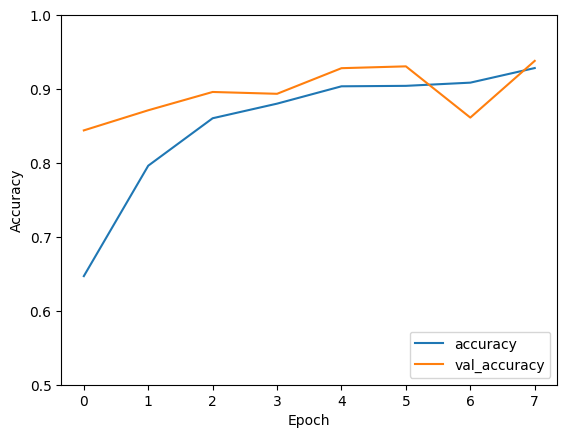

In [ ]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

test_loss, test_acc = model.evaluate(cleaned_val_ds, verbose=2)

In [ ]:
model.summary()

1/1 [==============================] - 0s 123ms/step


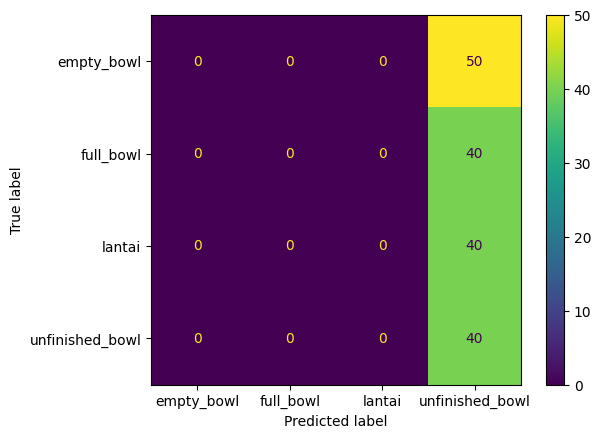

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay
import numpy as np

y_true = []
y_pred = []

for images, labels in test_dataset:
    predictions = model.predict(images)

    # Convert softmax probabilities to class labels
    predicted_labels = np.argmax(predictions, axis=1)

    y_true.extend(labels)
    y_pred.extend(predicted_labels)

cm = tf.math.confusion_matrix(y_true, y_pred, num_classes=4)

# Convert the TensorFlow tensor to a NumPy array for easier manipulation
confusion_matrix = cm.numpy()

# Print or use the confusion matrix as needed
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix, display_labels=['empty_bowl', 'full_bowl', 'lantai', 'unfinished_bowl'])
disp.plot()

In [ ]:
model.evaluate(test_dataset)

6/6 [==============================] - 21s 4s/step - loss: 102.1428 - accuracy: 0.2353


[102.14280700683594, 0.23529411852359772]

In [ ]:
import cv2

test_img = cv2.imread("/content/drive/MyDrive/pet_bowl_dataset/test1/IMG20231021182439.jpg")
test_img = cv2.resize(test_img, IMG_SIZE)

prediction = model.predict(tf.expand_dims(test_img, axis=0))

print(list(prediction))

1/1 [==============================] - 0s 31ms/step
[array([1., 0., 0., 0.], dtype=float32)]


## Second Iteration

In [ ]:
model = tf.keras.Sequential([
  tf.keras.layers.Conv2D(16, 3, padding='same', activation='relu'),
  tf.keras.layers.AveragePooling2D(),
  tf.keras.layers.Conv2D(32, 3, padding='same', activation='relu'),
  tf.keras.layers.AveragePooling2D(),
  tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu'),
  tf.keras.layers.AveragePooling2D(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(4, activation='softmax')
])

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

epochs=10
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=0,
    verbose=1,
    restore_best_weights=True,
    start_from_epoch=5
)

history = model.fit(
  cleaned_train_ds,
  validation_data=cleaned_val_ds,
  epochs=epochs,
  callbacks=[early_stopping]
)

In [ ]:
SAVED_MODEL_PATH = "drive/MyDrive/cnn_training/pet_bowl_classification/cnn_v2_keras.keras"
model.save(SAVED_MODEL_PATH, save_format="keras")

In [ ]:
loaded_model = tf.keras.models.load_model("drive/MyDrive/cnn_training/pet_bowl_classification/cnn_v2_keras.keras")
# test_loss, test_acc = loaded_model.evaluate(cleaned_val_ds, verbose=2)

In [ ]:
converter = tf.lite.TFLiteConverter.from_keras_model(loaded_model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_model = converter.convert()

with open('drive/MyDrive/cnn_training/pet_bowl_classification/cnn_v2_keras.tflite', 'wb') as f:
  f.write(tflite_model)

In [ ]:
loaded_model.evaluate(test_dataset)

6/6 [==============================] - 49s 8s/step - loss: 69.2907 - accuracy: 0.8059


[69.29072570800781, 0.8058823347091675]

1/1 [==============================] - 0s 163ms/step


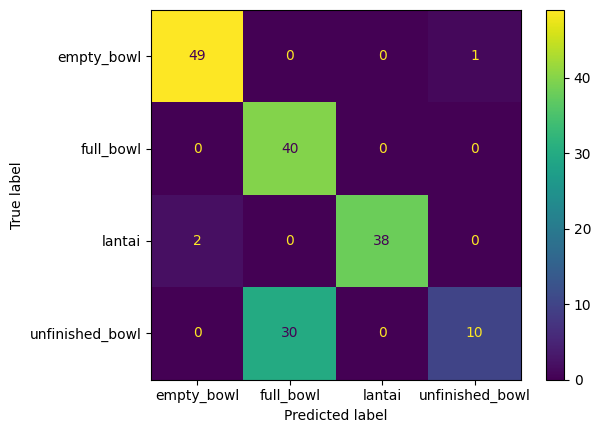

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay
import numpy as np

y_true = []
y_pred = []

for images, labels in test_dataset:
    predictions = model.predict(images)

    # Convert softmax probabilities to class labels
    predicted_labels = np.argmax(predictions, axis=1)

    y_true.extend(labels)
    y_pred.extend(predicted_labels)

cm = tf.math.confusion_matrix(y_true, y_pred, num_classes=4)

# Convert the TensorFlow tensor to a NumPy array for easier manipulation
confusion_matrix = cm.numpy()

# Print or use the confusion matrix as needed
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix, display_labels=['empty_bowl', 'full_bowl', 'lantai', 'unfinished_bowl'])
disp.plot()

In [ ]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

test_loss, test_acc = model.evaluate(cleaned_val_ds, verbose=2)

In [ ]:
%%time

import cv2

test_img = cv2.imread("/content/drive/MyDrive/pet_bowl_dataset/test1/IMG20231021182439.jpg")
# test_img = cv2.rotate(test_img, cv2.ROTATE_180)
test_img = cv2.resize(test_img, IMG_SIZE)
# test_img = cv2.cvtColor(test_img, cv2.COLOR_BGR2GRAY)

prediction = loaded_model.predict(tf.expand_dims(test_img, axis=0))

print(list(prediction))

1/1 [==============================] - 0s 127ms/step
[array([1., 0., 0., 0.], dtype=float32)]
CPU times: user 271 ms, sys: 66.8 ms, total: 338 ms
Wall time: 438 ms
